In [4]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart, CocoPairsRender, CocoPairsNetwork
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import asyncio
import datetime
import random


import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import plot_pose, get_humans_as_lines, plot_human_lines, is_same_image
import tensorflow as tf
import math
import copy
from tqdm import tqdm
import datetime
sys.path.insert(0, os.path.abspath('..'))


from tf_pose.tensblur.smoother import Smoother


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [18]:
# params 432, 368
w, h = 432, 368
image_path_source = './data/images/dri_source_2.jpg'
image_path_source_mask = './data/images/dri_source_2_mask.jpg'
image_path_target = './data/images/dri_target_far_2.jpg'
model = 'cmu'
log_dir = 'logs/'
resize_out_ratio = 2.0
image_source = common.read_imgfile(image_path_source, w, h)
image_target = common.read_imgfile(image_path_target, w, h)
image_source_mask = common.read_imgfile(image_path_source_mask, w, h, cv2.IMREAD_GRAYSCALE) > 0

summary_writer = tf.summary.FileWriter(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [6]:
e_source = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
e_target = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
upsample_size = [int(e_target.target_size[1] / 8 * resize_out_ratio), int(e_target.target_size[0] / 8 * resize_out_ratio)]

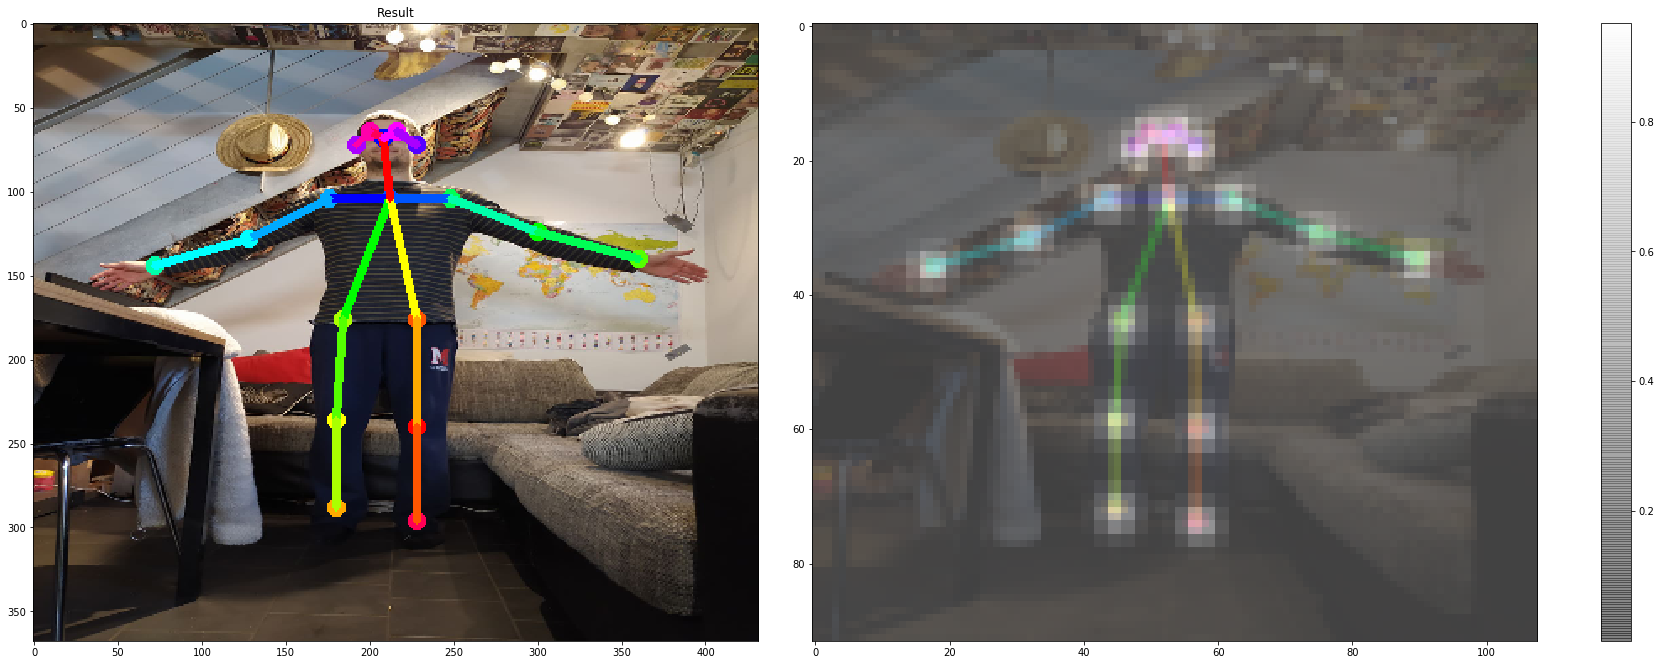

In [7]:
human_source = e_source.inference(image_source, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_source, human_source, e_source.heatMat)

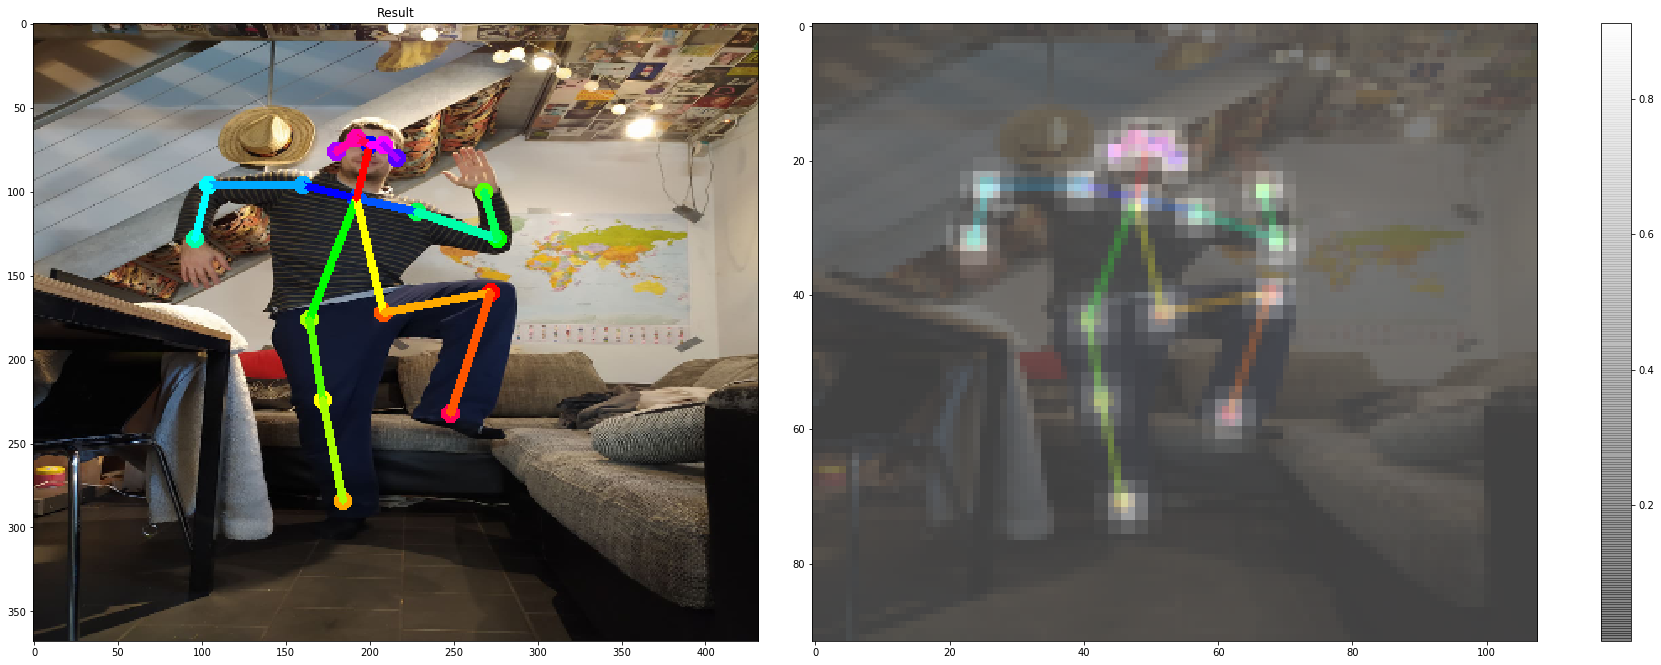

In [8]:
human_target = e_target.inference(image_target, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_target, human_target, e_target.heatMat)

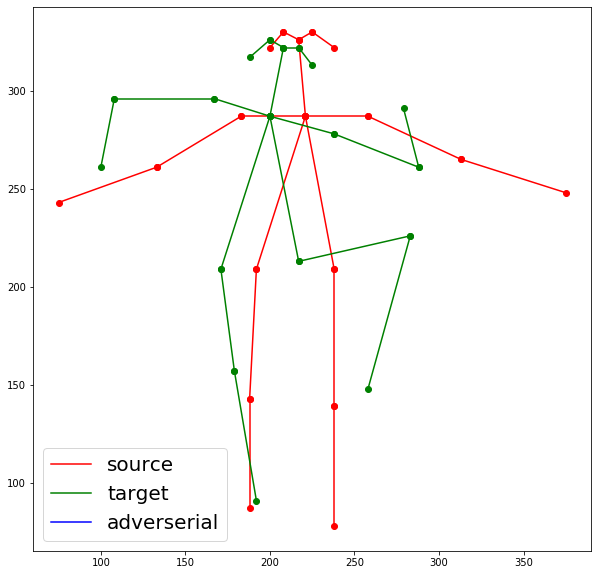

In [9]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [10]:
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = e_target.persistent_sess.run(
            [e_target.tensor_output, e_target.tensor_heatMat_up, e_target.tensor_pafMat_up, e_target.tensor_peaks],
            feed_dict={
                e_target.tensor_image: [image_target],
                e_target.upsample_size: upsample_size
            }
        )

source_np, source_np_heat, source_np_paf, source_np_peaks = e_source.persistent_sess.run(
            [e_source.tensor_output, e_source.tensor_heatMat_up, e_source.tensor_pafMat_up, e_source.tensor_peaks],
            feed_dict={
                e_source.tensor_image: [image_source],
                e_source.upsample_size: upsample_size
            }
        )


In [8]:
"""

ONLY_HEAT = True
USE_PEAK_AS_HEAT = False
# change only the heatmap for the wrist and the required limb vector field
# wrist
temp_target = copy.deepcopy(source_np_heat)
if USE_PEAK_AS_HEAT:
    temp_target[:, :, :, CocoPart.RWrist.value] = target_np_heat[:, :, :, CocoPart.RWrist.value]
else:
    temp_target[:, :, :, CocoPart.RWrist.value] = target_np_peaks[:, :, :, CocoPart.RWrist.value]

target_np_heat = temp_target


# lower arm 
temp_target = copy.deepcopy(source_np_paf)
if ONLY_HEAT:
    LOWER_ARM_RIGTH = 3
    id = CocoPairsNetwork[LOWER_ARM_RIGTH][0]
    temp_target[:, :, :, id] = target_np_paf[:, :, :, id]
    temp_target[:, :, :, id + 1] = target_np_paf[:, :, :, id + 1]

target_np_paf = temp_target

# set the correct peaks
temp_target = copy.deepcopy(source_np_peaks)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np_peaks[:, :, :, CocoPart.RWrist.value]
target_np_peaks = temp_target

# change the output as well
temp_target = copy.deepcopy(source_np)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np[:, :, :, CocoPart.RWrist.value]
if ONLY_HEAT:
    temp_target[:, :, :, id + 19] = target_np[:, :, :, id + 19]
    temp_target[:, :, :, id + 19 + 1] = target_np[:, :, :, id + 19 + 1]
target_np = temp_target
"""

'\n\nONLY_HEAT = True\nUSE_PEAK_AS_HEAT = False\n# change only the heatmap for the wrist and the required limb vector field\n# wrist\ntemp_target = copy.deepcopy(source_np_heat)\nif USE_PEAK_AS_HEAT:\n    temp_target[:, :, :, CocoPart.RWrist.value] = target_np_heat[:, :, :, CocoPart.RWrist.value]\nelse:\n    temp_target[:, :, :, CocoPart.RWrist.value] = target_np_peaks[:, :, :, CocoPart.RWrist.value]\n\ntarget_np_heat = temp_target\n\n\n# lower arm \ntemp_target = copy.deepcopy(source_np_paf)\nif ONLY_HEAT:\n    LOWER_ARM_RIGTH = 3\n    id = CocoPairsNetwork[LOWER_ARM_RIGTH][0]\n    temp_target[:, :, :, id] = target_np_paf[:, :, :, id]\n    temp_target[:, :, :, id + 1] = target_np_paf[:, :, :, id + 1]\n\ntarget_np_paf = temp_target\n\n# set the correct peaks\ntemp_target = copy.deepcopy(source_np_peaks)\ntemp_target[:, :, :, CocoPart.RWrist.value] = target_np_peaks[:, :, :, CocoPart.RWrist.value]\ntarget_np_peaks = temp_target\n\n# change the output as well\ntemp_target = copy.deepcopy

(1, 46, 54, 57)
(1, 92, 108, 19)
(1, 92, 108, 38)
(1, 92, 108, 19)


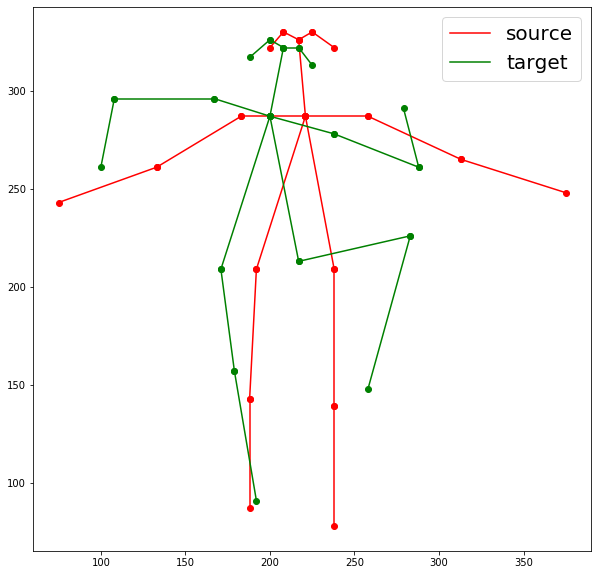

In [11]:
print(target_np.shape)
print(target_np_heat.shape)
print(target_np_paf.shape)
print(target_np_peaks.shape)

# for i in range(52):
#     print(np.sum(np.abs(target_np[:, :, :, i] - source_np[:, :, :, i])))


human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [12]:
# the target state
# the loss defined in the paper
def multi_stage_loss(target_heat, target_paf, start_stage=2):
    losses_per_stage = []
    # compute loss per stage
    for stage in range(start_stage, 7): 
        paf_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L1/BiasAdd').outputs[0]
        heat_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L2/BiasAdd').outputs[0]

        # compute the loss for every channel
        loss_paf = tf.nn.l2_loss(tf.concat(paf_op, axis=-1) - tf.concat(target_paf, axis=-1), name='AX_loss_l1_stage%d_' % (stage))
        loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage%d_' % (stage))
        losses_per_stage.append(tf.reduce_sum([loss_paf, loss_heat]))

    # combined loss form every stage
    total_loss = tf.reduce_sum(losses_per_stage)
    summary = tf.summary.scalar('grad_norm', total_loss)


    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, summary

# only use the final stage and only care about the hgeatmaps
def final_stage_heat_loss(target_heat):
    heat_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage6_L2/BiasAdd').outputs[0]
    
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage7_')

    # combined loss form every stage
    total_loss = tf.reduce_sum(loss_heat)
    summary = tf.summary.scalar('loss_heat', total_loss)

    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, summary

# only use a single heatmap for the loss
def final_stage_single_heat_loss(target_heat, index):
    heat_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage6_L2/BiasAdd').outputs[0][:, :, :, index]
    
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage7_')

    # combined loss form every stage
    total_loss = tf.reduce_sum(loss_heat)
    summary = tf.summary.scalar('loss_heat', total_loss)


    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, summary


def print_image_Stats(img):
    print(f'Min: {np.min(img)}')
    print(f'Max: {np.max(img)}')
    print(f'Avg: {np.average(img)}')
    

# compare two pose and return the total diff and the part switch moved the most
def compare_poses(pose1, pose2):
    total_diff = 0
    cur_max = 0
    most_moved_part = ''
    if(len(pose1.body_parts) != len(pose2.body_parts)):
        print('Poses have different length of body parts')
        return 0, 'NONE'
    for i in pose1.body_parts.keys():
        part1 = pose1.body_parts[i]
        part2 = pose2.body_parts[i]
        part1_pos =  np.array([part1.x, part1.y])
        part2_pos =  np.array([part2.x, part2.y])
        cur_diff = np.linalg.norm(part1_pos - part2_pos)
        if cur_diff > cur_max:
            most_moved_part = part1.get_part_name()
            cur_max = cur_diff
        total_diff += cur_diff
    return total_diff, most_moved_part

# compute the distance of a join between two poses
def compute_distance(pose1, pose2, index):
    if index not in pose1.body_parts or index not in pose2.body_parts:
        print(f'{index} not in both poses found')
        return 0
    part1 = pose1.body_parts[index]
    part2 = pose2.body_parts[index]
    part1_pos =  np.array([part1.x, part1.y])
    part2_pos =  np.array([part2.x, part2.y])
    return np.linalg.norm(part1_pos - part2_pos)

In [26]:
EPS = 5000
STEPS = 10
STAGE_INDEX = 2 # range from 2 to 6
ONLY_HEAT_MAP_AS_LOSS = False


if not "adv_image" in vars():
    adv_image = copy.deepcopy(image_source)
target_heat, grad_func, loss_func = [None, None, None]

human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


if ONLY_HEAT_MAP_AS_LOSS:
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
    grad_func, loss_func = final_stage_heat_loss(target_heat)
else:
    
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
    target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))
    grad_func, loss_func = multi_stage_loss(target_heat, target_paf, STAGE_INDEX)

for i in tqdm(range(STEPS)):    
    # compute gradient
    gradient, gn_summ = e_source.persistent_sess.run(
                [grad_func, loss_func],
                feed_dict={
                    target_heat: target_np[:, :, :, CocoPart.RWrist.value] if ONLY_HEAT_MAP_AS_LOSS else target_np[:, :, :, :19],
                    target_paf: target_np[:, :, :, 19:],
                    e_source.tensor_image: [adv_image],
                    e_source.upsample_size: upsample_size
                }
            )
    summary_writer.add_summary(gn_summ, i)  
    if i % 20 == 0:
        summary_writer.flush()
    
    
    ### ================= UPDATE STEP ================= ###
    #adv_image = adv_image - EPS * np.sign(gradient[0])
    scaled_gradient = image_source_mask[...,None] * (EPS * gradient[0])
    adv_image = adv_image - scaled_gradient
    adv_image = np.clip(adv_image, 0, 255)

summary_writer.flush()

human_adv = e_source.inference(adv_image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
    
print_image_Stats(image_source)
print_image_Stats(adv_image)
total_diff, most_moved_part = compare_poses(human_source[0], human_adv[0])
print(f'The total diff is {total_diff} and the part moved the most is the {most_moved_part}')

100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


Min: 0
Max: 255
Avg: 88.26177536231884
Min: 0.0
Max: 255.0
Avg: 90.6435317993164
Poses have different length of body parts
The total diff is 0 and the part moved the most is the NONE


2020-01-28 15:29:18,374 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 368, 432, 3)
Min: -0.05877294763922691
Max: 0.06360850483179092
Avg: -2.996456203163689e-07


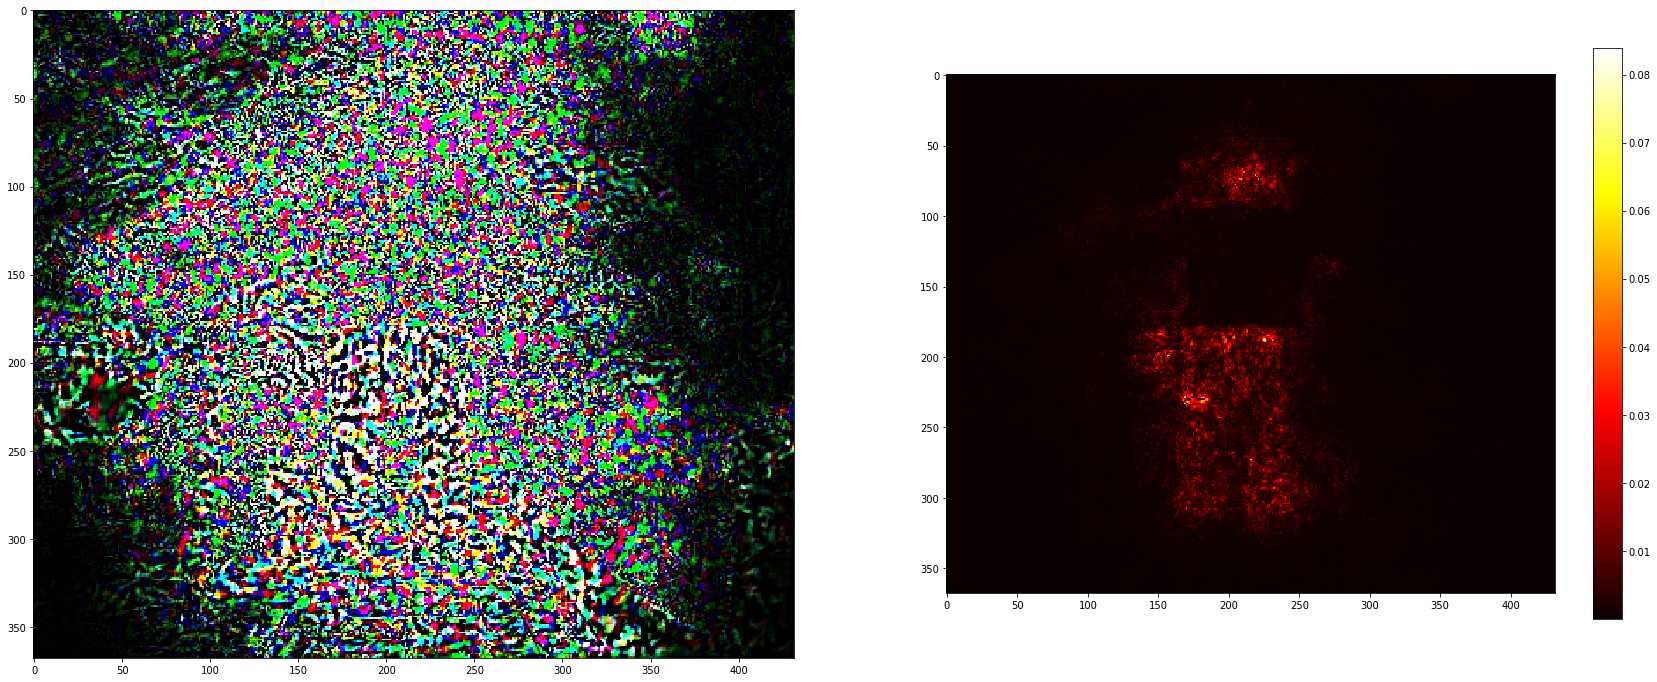

In [20]:
SCALE = 10000
print(gradient.shape)
print_image_Stats(gradient[0])
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(gradient[0] * SCALE)


grad_len = np.zeros((gradient[0].shape[:2]))
for y in range(gradient[0].shape[0]):
    for x in range(gradient[0].shape[1]):
        cur_vec = gradient[0, y, x]
        grad_len[y, x] = np.linalg.norm(cur_vec)

ax = fig.add_subplot(1, 2, 2)
heat_image = ax.imshow(grad_len, cmap='hot')
fig.colorbar(heat_image, ax=ax, shrink=0.35)

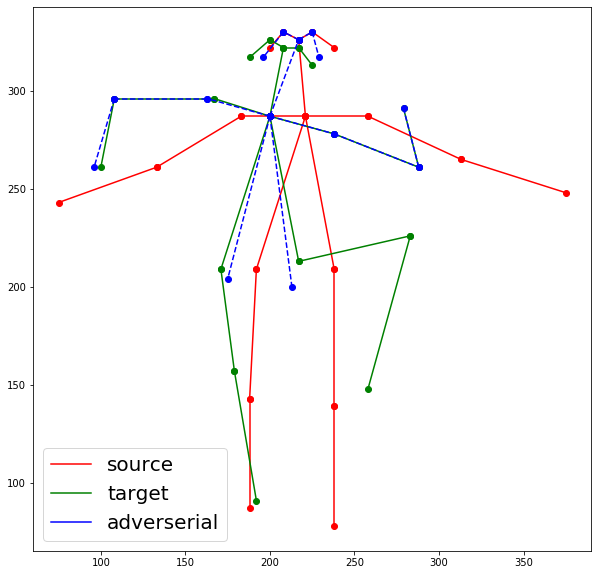

In [27]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)
adv_lines = get_humans_as_lines(human_adv, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')
plot_human_lines(adv_lines, ax, color='b', linestyle='--', label='adv')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

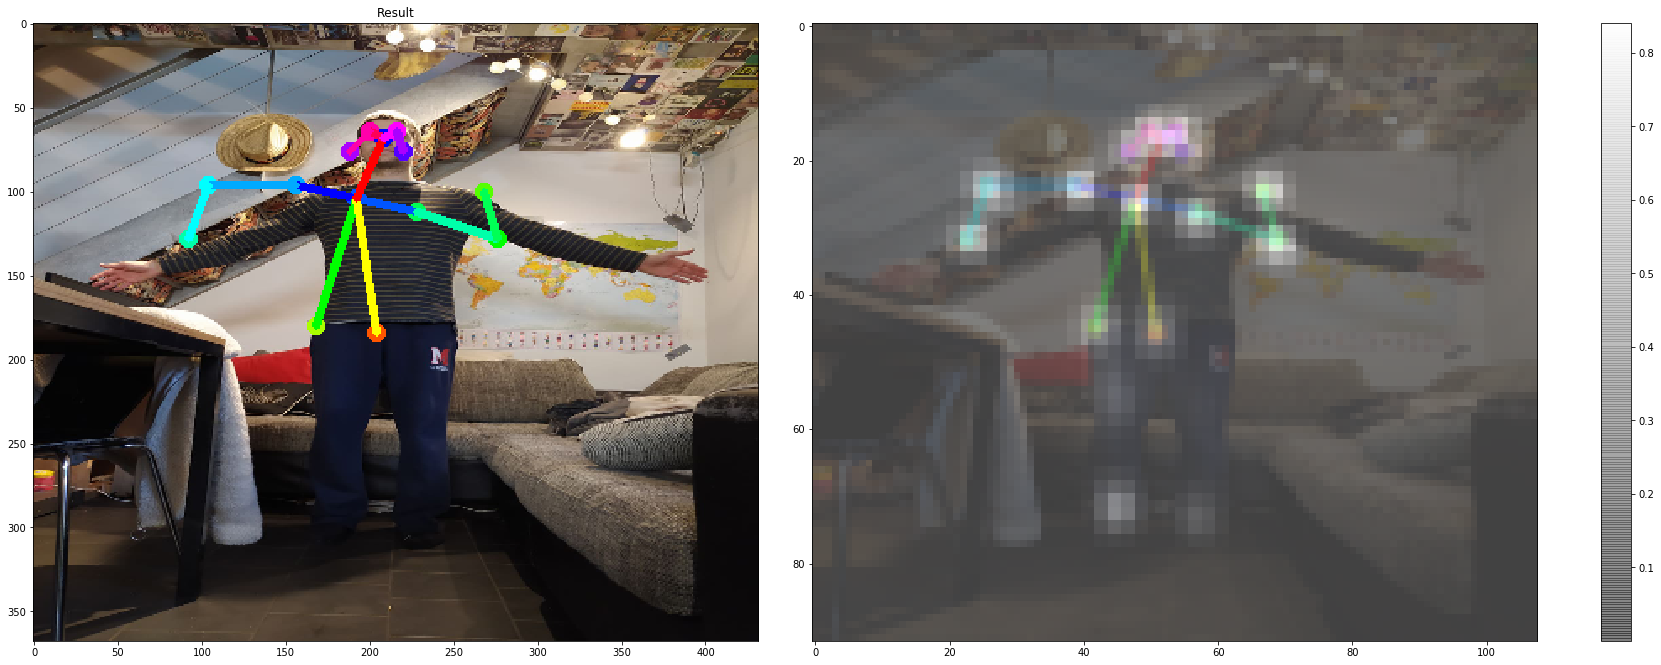

In [29]:
plot_pose(image_source, human_adv, e_source.heatMat)

2020-01-28 15:29:44,724 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


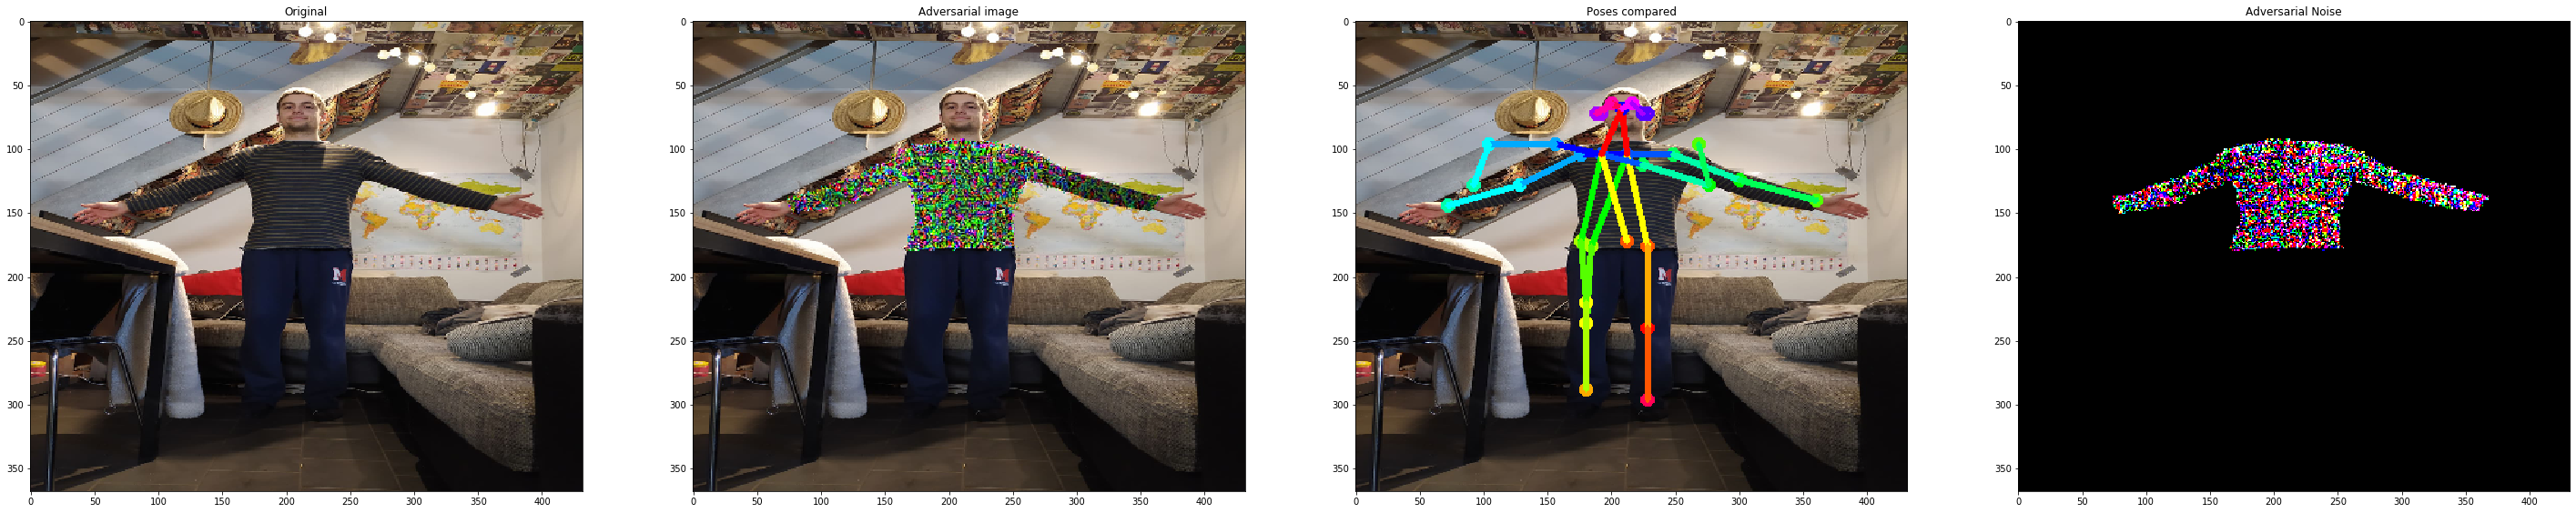

In [23]:
fig = plt.figure(figsize=(50, 25))

ax = fig.add_subplot(1, 4, 1)
ax.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
ax.set_title('Original')

adv_image_cliped = np.clip(adv_image, 0, 255) / 255
ax = fig.add_subplot(1, 4, 2)
ax.imshow(cv2.cvtColor(adv_image_cliped, cv2.COLOR_BGR2RGB))
ax.set_title('Adversarial image')


image_source_result = TfPoseEstimator.draw_humans(image_source, human_source, imgcopy=True)
image_source_result = TfPoseEstimator.draw_humans(image_source_result, human_adv, imgcopy=True)

ax = fig.add_subplot(1, 4, 3)
ax.set_title('Poses compared')
ax.imshow(cv2.cvtColor(image_source_result, cv2.COLOR_BGR2RGB))

ax = fig.add_subplot(1, 4, 4)
ax.set_title('Adversarial Noise')
noise = image_source - adv_image
ax.imshow(noise)

39.51681


Text(0.5, 1.0, 'Difference')

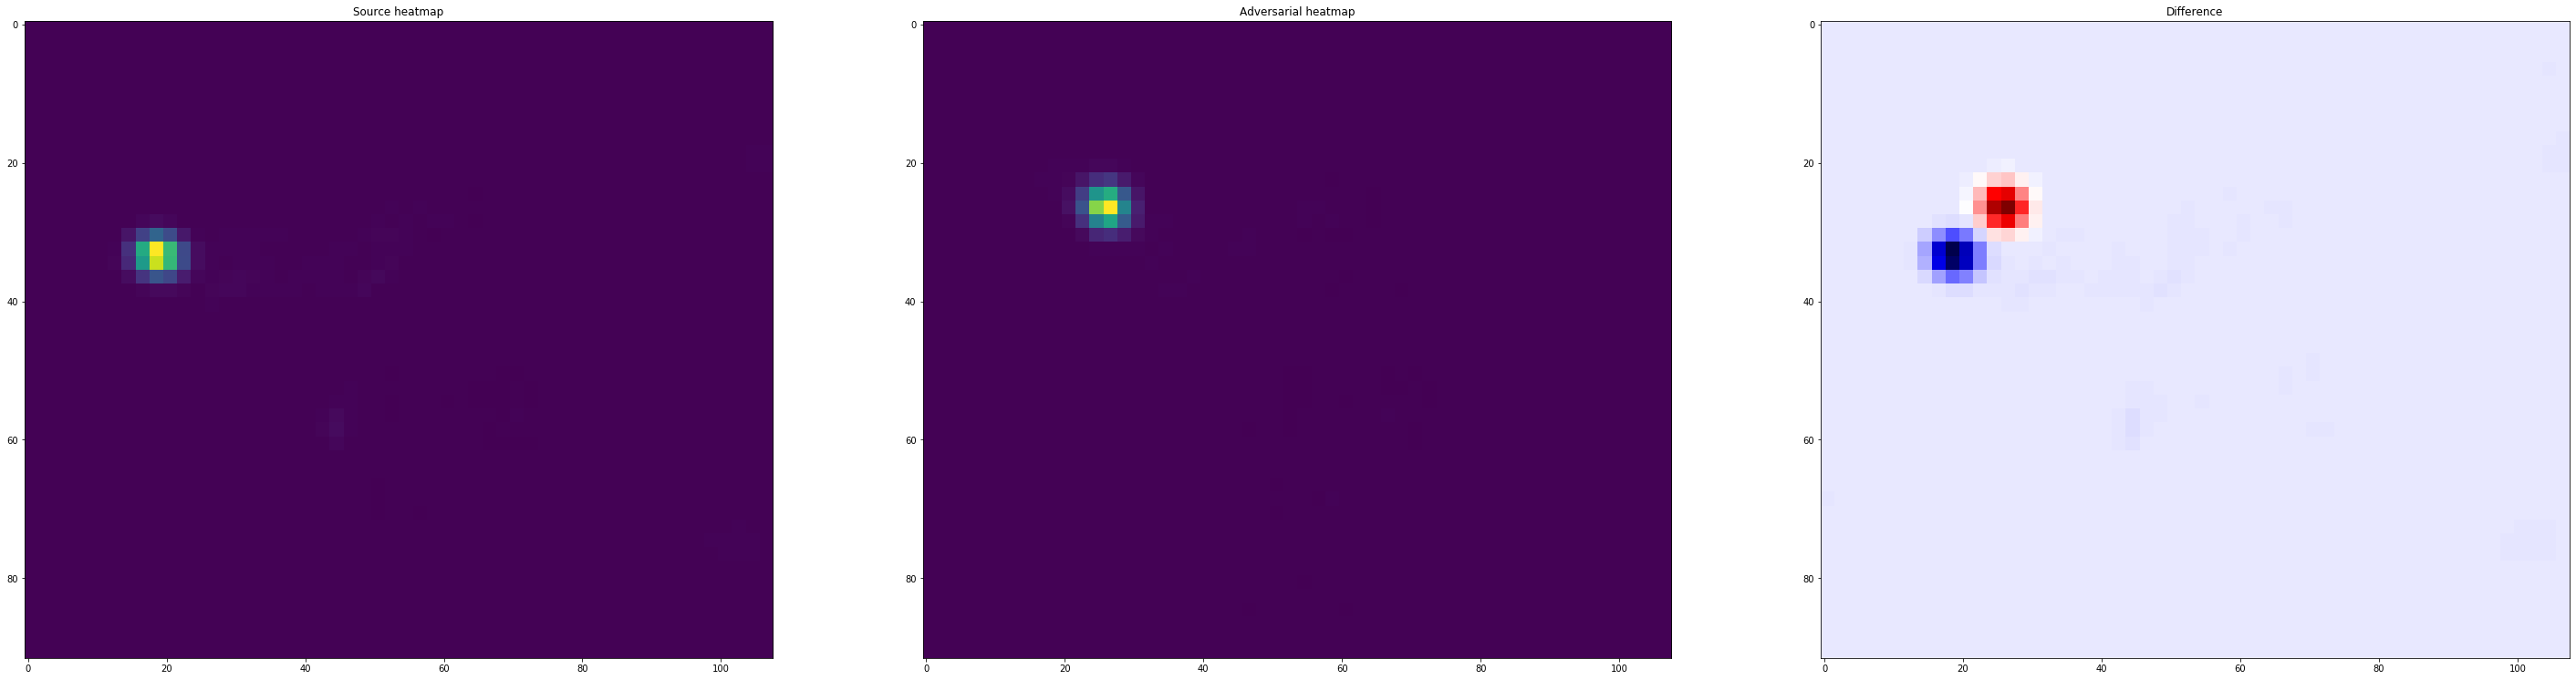

In [20]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_heat[0,: ,:, CocoPart.RWrist.value])
ax.set_title('Source heatmap')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value])
ax.set_title('Adversarial heatmap')

print(is_same_image(source_np_heat[0,: ,:, CocoPart.RWrist.value], e_source.heatMat[:,:, CocoPart.RWrist.value]))
ax = fig.add_subplot(1, 3, 3)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value] - source_np_heat[0,: ,:, CocoPart.RWrist.value], cmap='seismic')
ax.set_title('Difference')

In [20]:
def compute_peaks(tensor_heat_placeholder):
    tensor_heatMat_up = tf.image.resize_area(tensor_heat_placeholder, upsample_size,
                                                          align_corners=False, name='upsample_heatmat')

    smoother = Smoother({'data': tensor_heatMat_up}, 25, 3.0)
    gaussian_heatMat = smoother.get_output()

    max_pooled_in_tensor = tf.nn.pool(gaussian_heatMat, window_shape=(3, 3), pooling_type='MAX', padding='SAME')
    tensor_mask = tf.equal(gaussian_heatMat, max_pooled_in_tensor)
    tensor_peaks = tf.where(tensor_mask, gaussian_heatMat, tf.zeros_like(gaussian_heatMat))
    e_source.persistent_sess.run(tf.variables_initializer(
            [v for v in tf.global_variables() if
             v.name.split(':')[0] in [x.decode('utf-8') for x in
                                      e_source.persistent_sess.run(tf.report_uninitialized_variables())]
             ])
        )
    return tensor_peaks




tensor_heat_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
tensor_peaks = compute_peaks(tensor_heat_placeholder)

# run for adversarial imape 
[adv_np_peaks] = e_source.persistent_sess.run(
    [tensor_peaks],
            feed_dict={
                tensor_heat_placeholder: np.expand_dims(e_source.heatMat, axis=0)
            }
        )

Over all difference 0.1772901862859726
Localation of the peak in source (33, 19)
Localation of the peak in adv (26, 26)
Localation of the peak in target (26, 26)


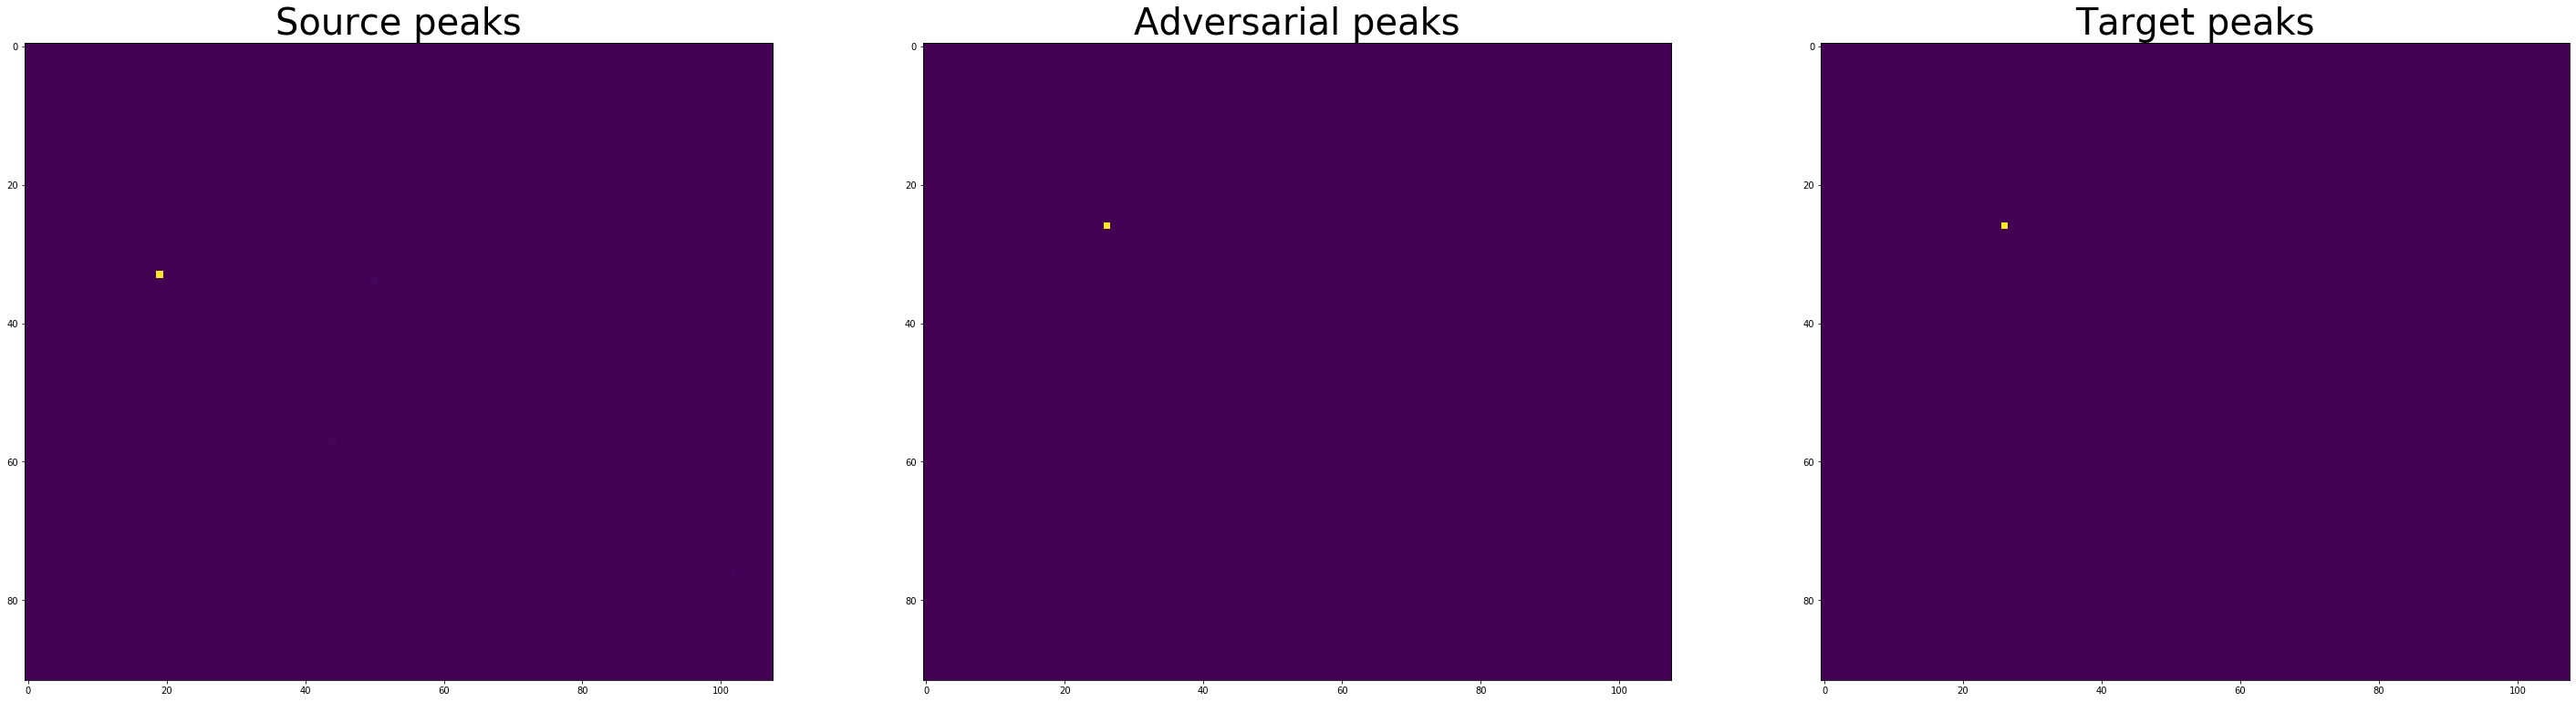

In [21]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_peaks[0,: ,:, CocoPart.RWrist.value])
ax.set_title('Source peaks', fontdict = {'fontsize' : 40})

ax = fig.add_subplot(1, 3, 2)
ax.imshow(adv_np_peaks[0, :,:, CocoPart.RWrist.value])
ax.set_title('Adversarial peaks', fontdict = {'fontsize' : 40})

print(f'Over all difference {is_same_image(adv_np_peaks[0, : ,:, CocoPart.RWrist.value], source_np_peaks[0, :, :, CocoPart.RWrist.value])}')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(target_np_peaks[0, :,:, CocoPart.RWrist.value])
ax.set_title('Target peaks', fontdict = {'fontsize' : 40})

print(f'Localation of the peak in source {np.unravel_index(source_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), source_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')
print(f'Localation of the peak in adv {np.unravel_index(adv_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), adv_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')

print(f'Localation of the peak in target {np.unravel_index(target_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), target_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')

In [35]:
from deepexplain.tf.v1_x import DeepExplain

with DeepExplain(session=e_source.persistent_sess, graph=e_source.graph) as de:
        
        input_tensor = e_source.tensor_image
        output_tensor = e_source.tensor_heatMat[:, :, :, CocoPart.RWrist.value]
        xs = tf.expand_dims(image_source, 0).eval(session=e_source.persistent_sess)
        xs = xs.astype('float64')
       
        Y_shape=[None] + [1, 46, 54] # size of heatmaps
        
        #ys = np.expand_dims(np.expand_dims(current_stats["mask"], axis=0), axis=0)
        
        baseline = np.zeros(list(xs.shape)[1:]) # baseline to compare against
        saliency = de.explain('saliency', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape)
        gradInput = de.explain('grad*input', T=output_tensor, X=input_tensor, xs=xs,  Y_shape=Y_shape)

/home/ax/master/2019_02/masterThesis/DeepExplain/deepexplain/tf/v1_x/main.py:94: UserWarning: DeepExplain detected you are trying to use an attribution method that requires gradient override but the original gradient was used instead. You might have forgot to (re)create your graph within the DeepExlain context. Results are not reliable!
  warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '


2020-01-24 16:51:53,348 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2020-01-24 16:51:53,367 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


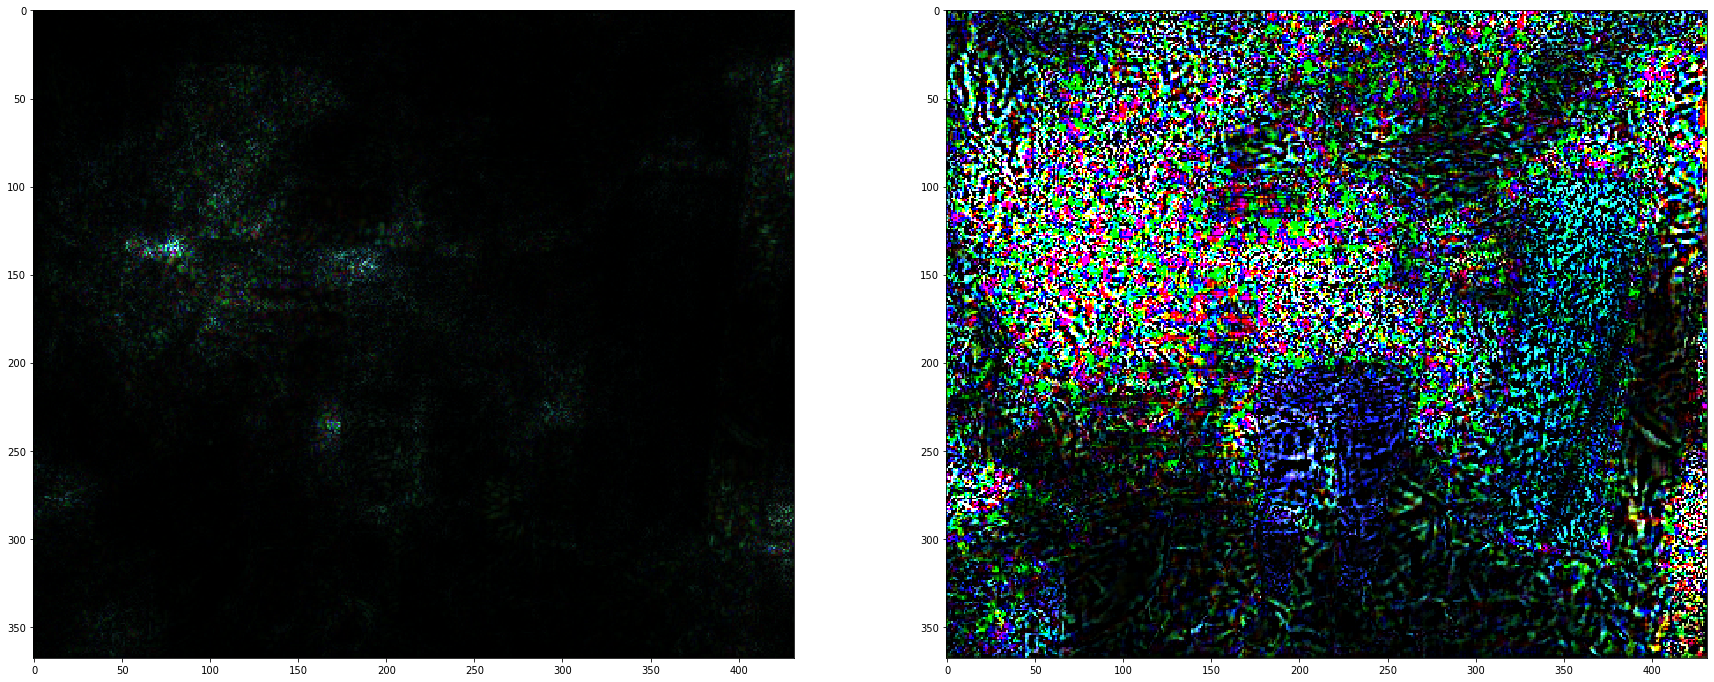

In [36]:
SCALE = 1000
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(saliency[0] * SCALE)

ax = fig.add_subplot(1, 2, 2)
heat_image = ax.imshow(gradInput[0] * SCALE, cmap='hot')